In [1]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model

def vgg16_model(trainable=True):
    base_model = VGG16(False, weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = True
    
    last_conv_layer = base_model.get_layer("block5_conv3")
    x = GlobalAveragePooling2D()(last_conv_layer.output)
    x = Dense(512, activation="relu")(x)  
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation="sigmoid")(x)
    return Model(base_model.input, predictions)



model = vgg16_model(False)
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [2]:
from Datasets import Datasets

dataset_name = "Bradbury"
dataset = Datasets.datasets()[dataset_name]

In [3]:
from keras.applications.xception import preprocess_input
import numpy as np

# Add preprocessing
train_images = dataset[0].images
train_labels  = dataset[0].labels

test_images = dataset[1].images
test_labels = dataset[1].labels

validation_images = dataset[2].images
validation_labels = dataset[2].labels

In [ ]:
train_images.max(), train_images.min()

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from ProjectPaths import ProjectPaths

In [5]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range = 0.1,
    zoom_range = 0.15,
    shear_range = 0.15,                                
    #brightness_range = [0.9, 1.1],
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator()


In [6]:
batch_size = 64

train_generator = data_generator.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size, shuffle=False)

In [ ]:
from keras.callbacks import LearningRateScheduler

def schedule_lr(epoch):
    return 0.01

lrCallback = LearningRateScheduler(schedule_lr)

In [7]:
from keras.optimizers import SGD

epochs = 100
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [8]:
from PerformanceMetrics import PerformanceMetrics

model.compile(optimizer="adadelta", loss='binary_crossentropy',
                  metrics=['accuracy', PerformanceMetrics.precision,
                           PerformanceMetrics.recall, PerformanceMetrics.fmeasure])

In [9]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping




model_name = "vgg16_3t_wmp_wr_{}".format(dataset_name)

checkpoint_dir = ProjectPaths.instance().checkpoint_dir_for(model_name, batch_size, epochs)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

file_in_checkpoint_dir = ProjectPaths.instance().file_in_checkpoint_dir(model_name, batch_size,
                                                                 epochs,  model_name +
                                                                 "__{epoch:02d}_{val_acc:.2f}.hdf5")

early_stopping_callback = EarlyStopping(patience=5)
model_checkpoint_callback = ModelCheckpoint(file_in_checkpoint_dir, monitor='val_acc', verbose=True,
                                                save_weights_only=True,
                                                save_best_only=True)

log_dir = os.path.join(ProjectPaths.instance().log_dir, model_name)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0,  write_graph=False, write_images=False)


model.fit_generator(train_generator,
                    steps_per_epoch=len(train_labels) // batch_size, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
                    validation_data=test_generator,
                    validation_steps=len(test_labels))

Epoch 1/100
496/496 [==============================] - 43s 87ms/step - loss: 0.3261 - acc: 0.8632 - precision: 0.8625 - recall: 0.8688 - fmeasure: 0.8623 - val_loss: 0.2156 - val_acc: 0.9039 - val_precision: 0.9611 - val_recall: 0.8385 - val_fmeasure: 0.8937

Epoch 00001: val_acc improved from -inf to 0.90385, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_Bradbury_2019-01-11_64_100/vgg16_3t_wmp_wr_Bradbury__01_0.90.hdf5
Epoch 2/100
496/496 [==============================] - 43s 87ms/step - loss: 0.2077 - acc: 0.9127 - precision: 0.9187 - recall: 0.9109 - fmeasure: 0.9116 - val_loss: 0.1815 - val_acc: 0.9346 - val_precision: 0.8998 - val_recall: 0.9735 - val_fmeasure: 0.9344

Epoch 00002: val_acc improved from 0.90385 to 0.93456, saving model to /media/tim/Data/Work/CBS/DeepSolaris/Models/vgg16_3t_wmp_wr_Bradbury_2019-01-11_64_100/vgg16_3t_wmp_wr_Bradbury__02_0.93.hdf5
Epoch 3/100
496/496 [==============================] - 43s 87ms/step - loss: 0.1644 - acc

In [10]:
import pandas as pd

train_eval = model.evaluate(train_images, train_labels, batch_size)
test_eval = model.evaluate(test_images, test_labels, batch_size)
validation_eval = model.evaluate(validation_images, validation_labels, batch_size)

np_model_evaluations = np.array([train_eval, test_eval, validation_eval])

evaluations = pd.DataFrame(np_model_evaluations, columns=model.metrics_names)
print(evaluations.head())

3973/3973 [==============================] - 2s 400us/step
       loss       acc  precision    recall  fmeasure
0  0.128582  0.945651   0.904112  0.997233  0.947757
1  0.153467  0.941354   0.896292  0.995359  0.942363
2  0.146880  0.943368   0.902548  0.996169  0.946153


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def find_optimal_cutoff(target, predicted):
   """ Find the optimal probability cutoff point for a classification model related to event rate
   Parameters
   ----------
   target : Matrix with dependent or target data, where rows are observations

   predicted : Matrix with predicted data, where rows are observations

   Returns
   -------
   list type, with optimal cutoff value

   """
   fpr, tpr, threshold = roc_curve(target, predicted)
   i = np.arange(len(tpr))
   roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
   roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

   return list(roc_t['threshold'])

In [12]:
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_images, batch_size)

In [13]:
cut_off = find_optimal_cutoff(test_labels, test_predictions)
cut_off

/usr/lib/python3/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.9354197978973389]

In [14]:
predicted_labels = test_predictions > cut_off
confusion_matrix(test_labels, predicted_labels)


array([[1961,   54],
       [  53, 1905]])

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2015
          1       0.97      0.97      0.97      1958

avg / total       0.97      0.97      0.97      3973



# Aachen

In [16]:
ac_dataset = Datasets.datasets()["AcMüDüHo"]

train_images = ac_dataset[0].images
train_labels = ac_dataset[0].labels

test_images = ac_dataset[1].images
test_labels = ac_dataset[1].labels

validation_images = ac_dataset[2].images
validation_labels = ac_dataset[2].labels

eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(eval_images.shape, eval_labels.shape)

(3357, 75, 75, 3) (374, 75, 75, 3) (934, 75, 75, 3)
(4665, 75, 75, 3) (4665,)


In [17]:
eval_predictions = model.predict(eval_images, batch_size) > cut_off
confusion_matrix(eval_labels, eval_predictions)

array([[2116,  218],
       [ 376, 1955]])

In [18]:
from sklearn.metrics import classification_report

print(classification_report(eval_labels, eval_predictions))

             precision    recall  f1-score   support

        0.0       0.85      0.91      0.88      2334
        1.0       0.90      0.84      0.87      2331

avg / total       0.87      0.87      0.87      4665



# Fresno

In [ ]:
fresno_dataset = Datasets.datasets()["Fresno"]

train_images = fresno_dataset[0].images
train_labels = fresno_dataset[0].labels

test_images = fresno_dataset[1].images
test_labels = fresno_dataset[1].labels

validation_images = fresno_dataset[2].images
validation_labels = fresno_dataset[2].labels

fresno_eval_images = np.concatenate((train_images, test_images, validation_images), axis=0)
fresno_eval_labels = np.concatenate((train_labels, test_labels, validation_labels), axis=0)


print(train_images.shape, test_images.shape, validation_images.shape)
print(fresno_eval_images.shape, fresno_eval_labels.shape)

In [ ]:
fresno_eval_predictions = model.predict(fresno_eval_images, batch_size) > cut_off
confusion_matrix(fresno_eval_labels, fresno_eval_predictions)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(fresno_eval_labels, fresno_eval_predictions))

# Heerlen Preprocessing

Now we use the trained model to preprocess the images from Heerlen and see how well it performs.

In [51]:
heerlen_dir = os.path.join(ProjectPaths.instance().image_dir, "Heerlen75x75")
image_files = [os.path.join(heerlen_dir, filename) for filename in os.listdir(heerlen_dir) if filename.endswith("rgb_2016.tiff") or filename.endswith("rgb_2017.tiff")]
image_files = sorted(image_files)
image_files[0:10]

['/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/00071b0a-e436-441d-9739-9911833434aa_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/000fac0e-c102-4af4-8314-d3f53016d465_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/001707ad-b863-480e-8aa9-061b151ae49f_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/001ee372-4d98-406e-81fb-b07711f14887_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0021b36e-80c2-4bc8-ad88-7fcd6290f757_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0025fd83-1c7f-4154-9e88-6c321a41466d_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/002f4183-23f7-49a0-9a04-414adf0ba3cf_rgb_2017.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/00304bff-a225-42bd-a269-e38331a21aa1_rgb_2016.tiff',
 '/media/tim/Data/Work/CBS/DeepSolaris/Images/Heerlen75x75/0031b200-bb4d-4af0-9738-c816f1c03a27_rgb_2017

In [ ]:
len(image_files)

In [20]:
def create_dir(path):
    if os.path.exists(path):
        return
    os.makedirs(path)

In [81]:
preprocessed_dir = os.path.join(ProjectPaths.instance().image_dir, "Heerlen75x75_preprocessed")
positives_dir = os.path.join(preprocessed_dir, "Positives")
negatives_dir = os.path.join(preprocessed_dir, "Negatives")

create_dir(positives_dir)
create_dir(negatives_dir)


In [43]:
img = load_img(image_files[0])    
img_array = img_to_array(img).astype(np.uint8)
image_rescaled = rescale(img_array, 0.25 / 0.2, anti_aliasing=False)
image_rescaled.shape

height, width, _ = image_rescaled.shape
mY = height // 2
mX = width // 2
x1 = mX - 37
x2 = mX + 38
y1 = mY - 37
y2 = mY + 38

image_rescaled.shape, mX, mY, x1, x2, y1, y2, image_rescaled.min(), image_rescaled.max() 

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


((94, 94, 3), 47, 47, 10, 85, 10, 85, 0.19215686274509802, 0.73044741210200659)

In [107]:
0.25/0.2

1.25

In [100]:
from keras.preprocessing.image import load_img, img_to_array 
from keras.applications.vgg16 import preprocess_input
from skimage.transform import rescale

def prepare_image(filename):
    img = load_img(filename)    
    img_array = img_to_array(img).astype(np.uint8)
    image_rescaled = rescale(img_array, 0.25 / 0.2, anti_aliasing=False)
    height, width, _ = image_rescaled.shape
    mY = height // 2
    mX = width // 2
    x1 = mX - 37
    x2 = mX + 38
    y1 = mY - 37
    y2 = mY + 38
    return image_rescaled[y1:y2,x1:x2, ::-1]

def image_generator(image_files, batch_size):
    batch = []
    for i, filename in enumerate(image_files):
        if i > 0 and (i % batch_size == 0):
            old_batch = batch
            batch = []
            yield np.array(old_batch)
        batch.append(prepare_image(filename))
    #if len(batch) > 0:
    #    repeat_last = len(batch) - batch_size
    #    repeated_images = [batch[-1] for i in range(repeat_last)]
    #   yield np.array(batch + repeated_images)

heerlen_image_generator = image_generator(image_files, batch_size)

In [47]:
img = next(heerlen_image_generator)
img.shape

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(64, 75, 75, 3)

In [48]:
img = load_img(image_files[0])

i = prepare_image(image_files[0])
img.size, i.shape
#plt.imshow(i)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


((75, 75), (75, 75, 3))

Predict labels for the images in the source directory and write them to positive or negative directory based on the prediction

In [101]:
predictions = model.predict_generator(heerlen_image_generator, steps=len(image_files) // batch_size)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [102]:
predictions = predictions.reshape(predictions.shape[0])
predictions.shape

(10560,)

In [106]:
(predictions > cut_off).sum(), (predictions <= cut_off).sum()

(1815, 8745)

In [82]:
from shutil import copyfile

positive_predictions = []
negative_predictions = []
for i, file_path in enumerate(image_files):        
    filename = os.path.basename(file_path)
    if i >= predictions.shape[0]:
        break
    
    prediction = predictions[i]    
    if prediction > cut_off:
        output_path = os.path.join(positives_dir, filename)
        positive_predictions.append(prediction)
    else:        
        output_path = os.path.join(negatives_dir, filename)
        negative_predictions.append(prediction)
    copyfile(file_path, output_path)

In [59]:
len(os.listdir(positives_dir)), len(os.listdir(negatives_dir))

(1815, 8745)

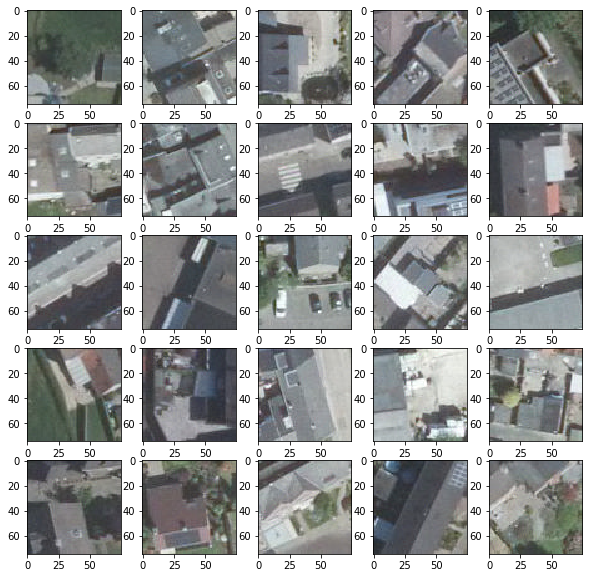

In [83]:
positive_images = [load_img(os.path.join(positives_dir, image)) for i, image in enumerate(os.listdir(positives_dir))]

_, ax = plt.subplots(5,5, figsize=(10,10))

j = 25
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(positive_images[j])     
        j += 1 


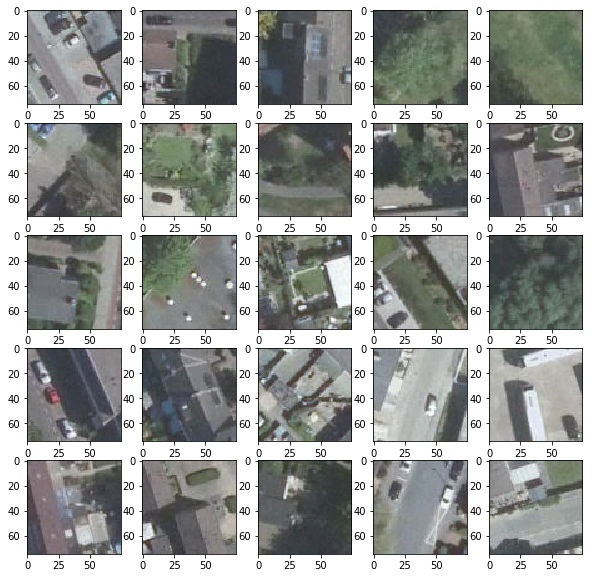

In [84]:
negative_images = [load_img(os.path.join(negatives_dir, image)) for i, image in enumerate(os.listdir(negatives_dir))]

_, ax = plt.subplots(5,5, figsize=(10,10))

j = 250
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(negative_images[j])     
        j += 1 


In [88]:
negative_predictions[250:275]

[0.69814879,
 0.16244835,
 0.77898854,
 0.31200716,
 0.81824738,
 0.78842288,
 0.035522394,
 0.65757799,
 0.0054925531,
 0.026087949,
 0.20953605,
 0.1605881,
 0.84439647,
 0.5669806,
 0.78510576,
 0.02459472,
 0.12280583,
 0.36973369,
 0.74406302,
 0.14411357,
 0.049324475,
 0.54634005,
 0.8387239,
 0.22050129,
 0.87049013]